In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [2]:
# Read the training data into a pandas dataframe
df = pd.read_csv('training.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
RefId                                72983 non-null int64
IsBadBuy                             72983 non-null int64
PurchDate                            72983 non-null object
Auction                              72983 non-null object
VehYear                              72983 non-null int64
VehicleAge                           72983 non-null int64
Make                                 72983 non-null object
Model                                72983 non-null object
Trim                                 70623 non-null object
SubModel                             72975 non-null object
Color                                72975 non-null object
Transmission                         72974 non-null object
WheelTypeID                          69814 non-null float64
WheelType                            69809 non-null object
VehOdo                               72983 non-null int64
Nationalit

In [4]:
# Class distribution of the target variable
df.IsBadBuy.value_counts()

0    64007
1     8976
Name: IsBadBuy, dtype: int64

In [5]:
# percentage skewness
(8976/(8976 + 64007)) * 100

12.298754504473644

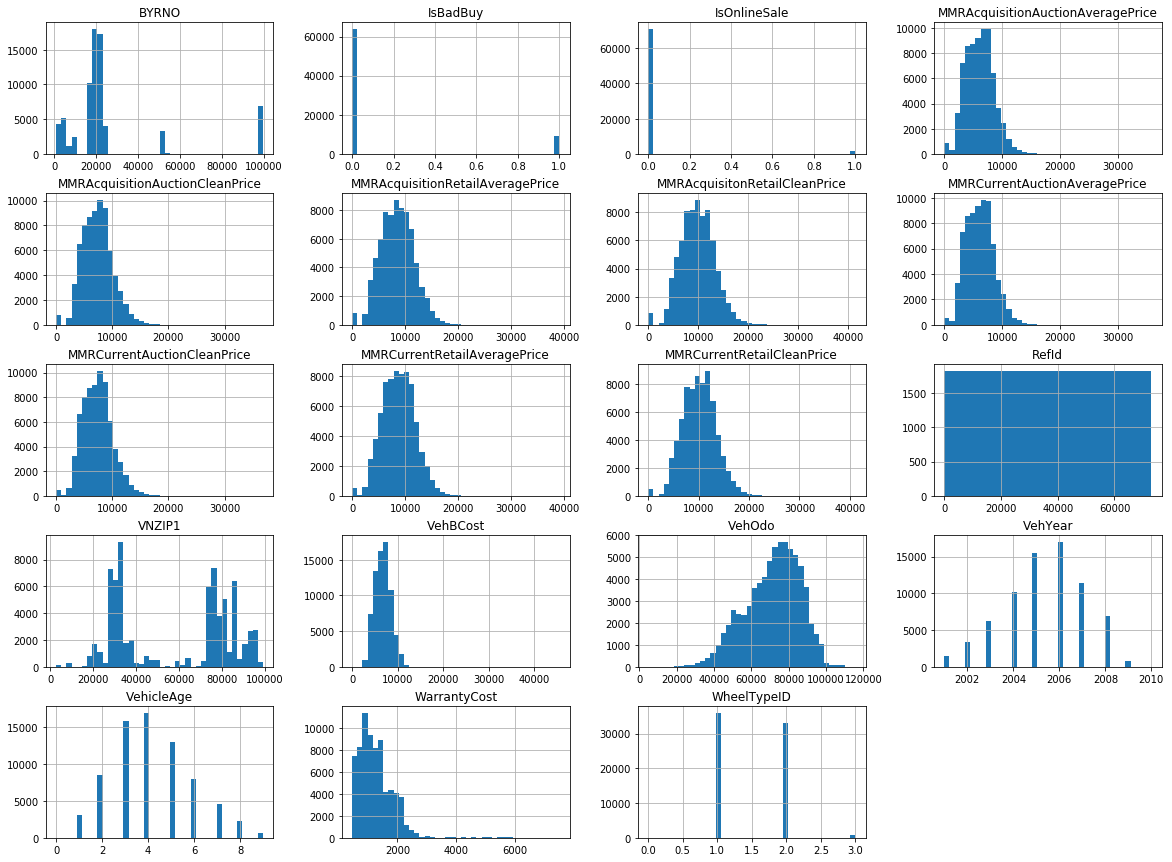

In [6]:
df.hist(bins=40, figsize=(20,15))
plt.show()

Variables which are highly autocorrelated or not relevant can be dropped: <br />
RefId (Serial Number) 
PurchDate + VehYear => VehicleAge 
WheelType => WheelTypeID 
VNST, VNZIP1 <br />
PRIMEUNIT, AUCGUART => most of the values are missing

In [7]:
# Summary of Categorical Variables
df.astype('object').describe()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
count,72983,72983,72983,72983,72983,72983,72983,72983,70623,72975,...,72668.0,72668.0,3419,3419,72983,72983,72983,72983.0,72983,72983
unique,72983,2,517,3,10,10,33,1063,134,863,...,12493.0,13192.0,2,2,74,153,37,2072.0,2,281
top,73014,0,11/23/2010,MANHEIM,2006,4,CHEVROLET,PT CRUISER,Bas,4D SEDAN,...,0.0,0.0,NO,GREEN,99761,32824,TX,7500.0,0,920
freq,1,64007,384,41043,17043,17013,17248,2329,13950,15236,...,504.0,504.0,3357,3340,3943,3699,13596,777.0,71138,2870


In [8]:
df.drop(['RefId', 'PurchDate', 'VehYear', 'WheelType', 'Color',\
         'VNST', 'PRIMEUNIT', 'AUCGUART'], axis=1, inplace=True)

In [9]:
# correlation of depeendent variables with target variable
df.corr(method='pearson', min_periods=5).IsBadBuy.sort_values()

MMRAcquisitionAuctionAveragePrice   -0.109252
MMRCurrentAuctionAveragePrice       -0.109112
MMRCurrentAuctionCleanPrice         -0.104020
MMRCurrentRetailAveragePrice        -0.103914
MMRAcquisitionAuctionCleanPrice     -0.102954
MMRCurrentRetailCleanPrice          -0.100245
VehBCost                            -0.099911
MMRAcquisitionRetailAveragePrice    -0.087418
MMRAcquisitonRetailCleanPrice       -0.083665
BYRNO                               -0.061488
WheelTypeID                         -0.044620
IsOnlineSale                        -0.003697
VNZIP1                               0.005796
WarrantyCost                         0.052319
VehOdo                               0.082560
VehicleAge                           0.167164
IsBadBuy                             1.000000
Name: IsBadBuy, dtype: float64

In [10]:
# Imputation of missing values
from sklearn.preprocessing import Imputer
num_imputer = Imputer(strategy='median', copy=False)

In [11]:
cat_columns = ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Transmission',\
               'Nationality', 'Size', 'TopThreeAmericanName', 'IsOnlineSale', 'WheelTypeID', 'VNZIP1']

In [12]:
col_map = {}
for col in cat_columns:
    col_map[col] = df.loc[:, (col)].mode().iloc[0]

In [13]:
#Feature Engineering
def feature_engg(df):
    df.loc[:, 'diff_1'] = df.MMRAcquisitionAuctionCleanPrice - df.MMRAcquisitionAuctionAveragePrice
    df.loc[:, 'diff_2'] = df.MMRAcquisitonRetailCleanPrice - df.MMRAcquisitionRetailAveragePrice
    df.loc[:, 'diff_3'] = df.MMRCurrentAuctionCleanPrice - df.MMRCurrentRetailCleanPrice

    # Difference of average acquisition prices
    df.loc[:, 'avg_diff_1'] = df.MMRAcquisitionRetailAveragePrice - df.MMRAcquisitionAuctionAveragePrice
    df.loc[:, 'avg_diff_2'] = df.MMRCurrentAuctionAveragePrice - df.MMRCurrentRetailAveragePrice
    df.loc[:, 'avg_diff_3'] = df.MMRCurrentRetailAveragePrice - df.MMRCurrentAuctionAveragePrice

    # Difference of current acquisition prices
    df.loc[:, 'curr_diff_2'] = df.MMRCurrentAuctionCleanPrice - df.MMRAcquisitonRetailCleanPrice
    df.loc[:, 'curr_diff_3'] = df.MMRCurrentRetailCleanPrice - df.MMRCurrentAuctionCleanPrice
    df.loc[:, 'curr_diff_4'] = df.MMRCurrentAuctionCleanPrice - df.MMRAcquisitionAuctionCleanPrice
    df.loc[:, 'curr_diff_5'] = df.MMRCurrentRetailCleanPrice - df.MMRAcquisitionAuctionCleanPrice

    df.loc[:,'diff1'] = (df.VehBCost + df.WarrantyCost) - df.MMRAcquisitionAuctionAveragePrice
    df.loc[:,'diff2'] = (df.VehBCost + df.WarrantyCost) - df.MMRCurrentAuctionAveragePrice

    df.loc[:, 'milesperyear'] = df.VehOdo / (df.VehicleAge+1)
    
    return df

In [14]:
df = feature_engg(df)

In [15]:
num_columns = ['VehOdo', 'VehicleAge', 'WarrantyCost', 'VehBCost', 'diff_1', 'diff_2', 'diff_3',\
              'avg_diff_1', 'avg_diff_2', 'avg_diff_3', 'curr_diff_2', 'curr_diff_3', 'curr_diff_4',\
               'curr_diff_5', 'diff1', 'diff2']

In [16]:
# Impute numerical columns
df.loc[:, (num_columns)] = num_imputer.fit_transform(df.loc[:, (num_columns)])

In [17]:
# Impute categorical columns
df.loc[:, (cat_columns)] = df.loc[:, (cat_columns)].fillna(df.loc[:, (cat_columns)].mode().iloc[0])

In [18]:
df.isna().any()

IsBadBuy                             False
Auction                              False
VehicleAge                           False
Make                                 False
Model                                False
Trim                                 False
SubModel                             False
Transmission                         False
WheelTypeID                          False
VehOdo                               False
Nationality                          False
Size                                 False
TopThreeAmericanName                 False
MMRAcquisitionAuctionAveragePrice     True
MMRAcquisitionAuctionCleanPrice       True
MMRAcquisitionRetailAveragePrice      True
MMRAcquisitonRetailCleanPrice         True
MMRCurrentAuctionAveragePrice         True
MMRCurrentAuctionCleanPrice           True
MMRCurrentRetailAveragePrice          True
MMRCurrentRetailCleanPrice            True
BYRNO                                False
VNZIP1                               False
VehBCost   

In [19]:
# Feature Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=False)
df.loc[:, (num_columns)] = scaler.fit_transform(df.loc[:, (num_columns)])

In [20]:
df_num = df.loc[:, (num_columns)]

In [21]:
df_num.shape

(72983, 16)

In [22]:
# Handling categorical features
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
new_df = []
les = {col:LabelEncoder() for col in cat_columns}
ohes = {col:OneHotEncoder() for col in cat_columns}
for col in cat_columns:
    le = les[col].fit_transform(df[col]).reshape(-1,1)
    result = ohes[col].fit_transform(le)
    new_df.append(pd.DataFrame(result.toarray(), columns=[col+str(cl) for cl in les[col].classes_]))

In [23]:
df_cat = pd.concat(new_df, axis=1, ignore_index=True)

In [24]:
df_cat.shape

(72983, 2278)

In [25]:
train = pd.concat([df_num, df_cat], axis=1, ignore_index=True)

In [26]:
train.shape

(72983, 2294)

In [27]:
from sklearn.model_selection import train_test_split
X, y = train.loc[:, ~train.columns.isin (['IsBadBuy'])], df.IsBadBuy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=41)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=2000, random_state=0, n_jobs=6)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
from sklearn.metrics import precision_score, recall_score
recall_score(y_test, clf.predict(X_test))
precision_score(y_test, clf.predict(X_test))

In [28]:
# Read the training data into a pandas dataframe
test = pd.read_csv('test.csv')

In [29]:
refids = test.RefId

In [30]:
test.drop(['RefId', 'PurchDate', 'VehYear', 'WheelType', 'Color',\
         'VNST', 'PRIMEUNIT', 'AUCGUART'], axis=1, inplace=True)

In [31]:
test = feature_engg(test)

In [32]:
test.loc[:, (num_columns)] = num_imputer.transform(test.loc[:, (num_columns)])
test.loc[:, (cat_columns)] = test.loc[:, (cat_columns)].fillna(test.loc[:, (cat_columns)].mode().iloc[0])
#test.isna().any()

In [33]:
test.loc[:, (num_columns)] = scaler.transform(test.loc[:, (num_columns)])

In [34]:
test_num = test.loc[:, (num_columns)]

In [35]:
test_num.shape

(48707, 16)

In [36]:
for col in cat_columns:
    test.loc[~test[col].isin (df[col].tolist()), col] = col_map[col]

In [37]:
new_df = []
for col in cat_columns:
    le = les[col].transform(test[col]).reshape(-1,1)
    result = ohes[col].transform(le)
    new_df.append(pd.DataFrame(result.toarray(), columns=[col+str(cl) for cl in les[col].classes_]))

test_cat = pd.concat(new_df, axis=1, ignore_index=True)
test = pd.concat([test_num, test_cat], axis=1, ignore_index=True)

In [38]:
test.shape

(48707, 2294)

In [ ]:
pred1 = lr.predict_proba(test)[:,1]
pred2 = clf.predict_proba(test)[:,1]

In [ ]:
df = pd.DataFrame({'RefId': refids, 'IsBadBuy': pred1})
df.to_csv('submission1.csv', columns=['RefId', 'IsBadBuy'], index=False)

In [ ]:
df = pd.DataFrame({'RefId': refids, 'IsBadBuy': pred2})
df.to_csv('submission2.csv', columns=['RefId', 'IsBadBuy'], index=False)

In [ ]:
# ToDo
#Choose best features
clf.feature_importances_